# Setting Up Environment

In [ ]:
import flax
import jax
import optax
import random
import pandas as pd
import numpy as np
import gc
import pickle
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns
import openai
from jax import numpy as jnp

from flax.training import train_state
from flax import linen

from google.colab import drive

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import entropy


from mpl_toolkits.mplot3d import Axes3D



In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

%cd drive/Shareddrives/InfoRetrievalProject/Project/

[Errno 2] No such file or directory: 'drive/Shareddrives/InfoRetrievalProject/Project/'
/content/drive/Shareddrives/InfoRetrievalProject/Project


# Load the model values

## Loading Data

In [ ]:
anime_df = pd.read_csv("data/anime.csv")
print("Anime : {}".format(anime_df.shape))
anime_df = anime_df.sort_values(by='anime_id').reset_index(drop=True)

Anime : (12294, 7)


## Loading Train and Test data

In [ ]:
# Load the CSV files into DataFrames
X_train_df = pd.read_csv("X_train.csv")
Y_train_df = pd.read_csv("Y_train.csv")
X_test_df = pd.read_csv("X_test.csv")
Y_test_df = pd.read_csv("Y_test.csv")

# Convert DataFrames back to NumPy arrays if needed
X_train = X_train_df.values
Y_train = Y_train_df.values.flatten()  # Flattening to convert to a 1D array
X_test = X_test_df.values
Y_test = Y_test_df.values.flatten()

# Display the shapes to verify
print("Shapes of the variables:")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

Shapes of the variables:
X_train: (5536847, 2)
Y_train: (5536847,)
X_test: (649215, 2)
Y_test: (649215,)


## Loading Seen and Unseen Ratings

In [ ]:
# Load the CSV files into DataFrames
ratings_df = pd.read_csv("ratings_df.csv")
ratings_unseen_df = pd.read_csv("ratings_df_unseen.csv")
ratings_df

<ipython-input-74-97da0a009dfc>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df = pd.read_csv("ratings_df.csv")


,user_id,anime_id,user_rating,name,genre,type,episodes,average_anime_rating,members
0,25006,621,10,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888
1,2471,275,7,D-Frag!,"Comedy, Game, School, Seinen",TV,12,7.75,154548
2,20484,1202,9,One Piece Film: Z,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",Movie,1,8.39,76051
3,16292,618,9,Oda Nobuna no Yabou,"Comedy, Historical, Romance",TV,12,7.70,133216
4,16069,1309,7,Joker Game,"Drama, Historical, Military",TV,12,7.21,102560
...,...,...,...,...,...,...,...,...,...
6186057,13262,1531,6,Shugo Chara!! Doki,"Comedy, Magic, School, Shoujo",TV,51,7.59,60384
6186058,33181,1031,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
6186059,44789,751,6,Rose of Versailles,"Adventure, Drama, Historical, Romance, Shoujo",TV,40,8.40,32188
6186060,3185,2547,10,Charlotte: Tsuyoi Monotachi,"School, Super Power",Special,1,7.56,39137


## Loading Mapping Dictionaries

In [ ]:
# Reading and converting dictionaries with int64
with open('real_to_mapped_user.json', 'r') as archivo:
    real_to_mapped_user_id = {np.int64(key): value for key, value in json.load(archivo).items()}

with open('mapped_to_real_user.json', 'r') as archivo:
    mapped_to_real_user_id = {key: np.int64(value) for key, value in json.load(archivo).items()}

with open('real_to_mapped_anime.json', 'r') as archivo:
    real_to_mapped_anime_id = {np.int64(key): value for key, value in json.load(archivo).items()}

with open('mapped_to_real_anime.json', 'r') as archivo:
    mapped_to_real_anime_id = {key: np.int64(value) for key, value in json.load(archivo).items()}

## Loading Pre Trained parameters

In [ ]:
# Load model parameters and losses
with open("model_outputs.pkl", "rb") as f:
    saved_data = pickle.load(f)

# Extract the components
loaded_final_params = saved_data["params"]
loaded_train_loss = saved_data["train_loss"]
loaded_test_loss = saved_data["test_loss"]

print("Model and losses loaded successfully!")


Model and losses loaded successfully!


## Create the model definition (With the trained parameters)

In [ ]:
## CREATE VARIABLES
n_items = len(set(ratings_df['anime_id']).union(ratings_unseen_df['anime_id']))
n_users = len(set(ratings_df['user_id']).union(ratings_unseen_df['user_id']))
ratings = ratings_df["user_rating"].unique()

print("Unique Items : {}".format(n_items))
print("Unique Users : {}".format(n_users))
print("Ratings : {}".format(ratings))

Unique Items : 9926
Unique Users : 66351
Ratings : [10  7  9  8  5  6  1  3  4  2]


In [ ]:
n_factors = 32

class SimpleRecSystem(linen.Module):
    """
    A simple recommendation system based on embeddings.

    Attributes:
        n_users (int): Number of unique users.
        n_items (int): Number of unique items.
        n_factors (int): Number of latent factors for embeddings.
    """

    n_users = n_users
    n_items = n_items
    n_factors = n_factors

    def setup(self):
        """
        Initializes the embeddings for users and items.

        Creates:
            self.user_embeddings (linen.Embed): Embedding layer for users.
            self.item_embeddings (linen.Embed): Embedding layer for items.
        """
        self.user_embeddings = linen.Embed(self.n_users, self.n_factors, name="User Embeddings")
        self.item_embeddings = linen.Embed(self.n_items, self.n_factors, name="Item Embeddings")

    def __call__(self, X_batch):
        """
        Computes the recommendation scores for a batch of user-item pairs.

        Args:
            X_batch (jnp.ndarray): A 2D array of shape (batch_size, 2), where each row contains
                                   a user ID (first column) and an item ID (second column).

        Returns:
            jnp.ndarray: A 1D array of shape (batch_size,) containing the recommendation scores
                         for each user-item pair in the batch.
        """
        users = self.user_embeddings(X_batch[:,0])
        items = self.item_embeddings(X_batch[:,1])

        return linen.relu((users * items).sum(axis=1))

    def get_item_embeddings(self, item_ids):
        """
        Fetches embeddings for specified item IDs.

        Args:
            item_ids (jnp.ndarray): A 1D array of item IDs for which to fetch embeddings.

        Returns:
            jnp.ndarray: A 2D array of shape (len(item_ids), n_factors) containing the embeddings
                         for the specified items.
        """
        return self.item_embeddings(item_ids)

    def get_user_embeddings(self, user_ids):
        """
        Fetches embeddings for specified user IDs.

        Args:
            user_ids (jnp.ndarray): A 1D array of user IDs for which to fetch embeddings.

        Returns:
            jnp.ndarray: A 2D array of shape (len(user_ids), n_factors) containing the embeddings
                         for the specified users.
        """
        return self.user_embeddings(user_ids)

In [ ]:
rec_system_loaded = SimpleRecSystem()
rng = np.random.RandomState(2)
learning_rate=0.01
optimizer = optax.nadam(learning_rate=learning_rate)


# Recreate the model state with loaded parameters
restored_model_state = train_state.TrainState.create(
    apply_fn=rec_system_loaded.apply,
    params=loaded_final_params,
    tx=optimizer
)

# Prediction (For a seen user)

In [ ]:
def make_predictions(rng, rec_system, state,user_id):
    """
    Generates predicted ratings for a specific user and adds them to the user's data.

    Args:
        rng (jax.random.PRNGKey): A random number generator key for JAX operations, if needed.
        rec_system (SimpleRecSystem): The recommendation system instance for making predictions.
        state (TrainState): The trained state of the model, containing parameters and the apply function.
        user_id (int): The ID of the user for whom predictions will be generated.

    Returns:
        pd.DataFrame: A DataFrame containing the user's data with predicted ratings added.
                      Columns include:
                        - "user_id": The user ID.
                        - "anime_id": The anime IDs.
                        - "user_rating": The user's actual ratings (if available).
                        - "pred_rating": The predicted ratings for the user.
                        - Other metadata such as "name", "genre", "type", "episodes",
                          "average_anime_rating", and "members".
        int: The ID of the user for reference.
    """

    cols_of_interest = ["user_id","anime_id","user_rating","name","genre","type","episodes","average_anime_rating","members"]
    user_data = ratings_df[ratings_df["user_id"] == user_id][cols_of_interest]
    preds = state.apply_fn(state.params, user_data[["user_id","anime_id"]].values)

    preds = jnp.clip(preds,1, 10.5)
    preds = np.array([math.ceil(pred) if (pred-int(pred)) > 0.5 else math.floor(pred) for pred in preds])
    user_data["pred_rating"] = preds
    cols_of_interest.insert(3, "pred_rating")
    return user_data[cols_of_interest], user_id


In [ ]:
rng = np.random.RandomState(2)
user_data, user_id = make_predictions(rng,rec_system_loaded, restored_model_state,2)
#user_data.sort_values(by=["user_rating"], ascending=False).head(20)
user_data

,user_id,anime_id,user_rating,pred_rating,name,genre,type,episodes,average_anime_rating,members
15873,2,304,5,1,Ichigo 100% OVA,"Comedy, Ecchi, Harem, Romance, School, Shounen",OVA,4,7.03,19508
70360,2,155,8,5,Steins;Gate: Oukoubakko no Poriomania,"Sci-Fi, Thriller",Special,1,8.46,159548
89976,2,40,7,6,Nanatsu no Taizai,"Action, Adventure, Ecchi, Fantasy, Shounen, Su...",TV,24,8.42,331627
96883,2,327,3,2,Tenjou Tenge: The Ultimate Fight,"Adventure, Drama, Martial Arts, Romance, Shoun...",OVA,2,7.18,29039
109874,2,192,8,7,Uchuu Kyoudai,"Comedy, Sci-Fi, Seinen, Slice of Life, Space",TV,99,8.59,72958
...,...,...,...,...,...,...,...,...,...,...
6067960,2,170,8,7,Danshi Koukousei no Nichijou,"Comedy, School, Shounen, Slice of Life",TV,12,8.35,258914
6117382,2,351,4,1,Onegai☆Teacher: Himitsu na Futari,"Comedy, Ecchi, Romance, Sci-Fi",OVA,1,7.42,32134
6153259,2,52,5,5,Pokemon Advanced Generation,"Action, Adventure, Comedy, Fantasy, Kids",TV,192,7.20,67386
6169774,2,406,6,4,Pokemon Housoukyoku,"Adventure, Comedy, Fantasy, Kids",TV,16,6.99,15461


# When a new user (Unseen from the model) wants a recommendation

In [ ]:
anime_embeddings = {}
for elem in ratings_df["anime_id"].unique():
    anime_embeddings[elem] = restored_model_state.apply_fn(restored_model_state.params, method=rec_system_loaded.get_item_embeddings, item_ids=elem)


In [ ]:
def get_top_k_closest(embeddings_dict, target_embedding, k=5, seen_animes_id=None):
    """
    Finds the top-k closest embeddings to a target embedding based on Euclidean distance.

    Args:
        embeddings_dict (dict): A dictionary where keys are anime IDs and values are
                                 their corresponding embeddings (1D arrays).
        target_embedding (jnp.ndarray): The target embedding to compare against,
                                         of shape (n_factors,).
        k (int, optional): The number of closest embeddings to return. Defaults to 5.
        seen_animes_id (list, optional): A list of anime IDs to exclude from consideration
                                         (e.g., already seen or rated by the user). Defaults to None.

    Returns:
        list: A list of the IDs of the top-k closest animes, sorted by distance in ascending order.
    """
    # Initialize seen_animes_id as an empty list if not provided
    if seen_animes_id is None:
        seen_animes_id = []

    # Extract anime IDs and their embeddings after filtering
    filtered_embeddings = {anime_id: embedding
                           for anime_id, embedding in embeddings_dict.items()
                           if anime_id not in seen_animes_id}

    # Filter out seen animes from the embeddings dictionary
    anime_ids = list(filtered_embeddings.keys())
    embeddings = jnp.array(list(filtered_embeddings.values()))

    # Compute Euclidean distances between the embeddings and the target embedding
    distances = jnp.linalg.norm(embeddings - target_embedding, axis=1)

    indices = jnp.argsort(distances)[:k]
    closest_ids = [anime_ids[i] for i in indices]
    closest_distances = distances[indices].tolist()

    return closest_ids


In [ ]:
def get_anime_info(anime_ids_list, mapped_to_real_dict):
    """
    Retrieves detailed information about a list of anime based on their IDs.

    Args:
        anime_ids_list (list): A list of anime IDs (integers or strings) to retrieve information for.
        mapped_to_real_dict (dict): A dictionary mapping anime IDs (as strings) to their
                                    corresponding real-world IDs used in the dataset.

    Returns:
        pd.DataFrame: A DataFrame containing information about the animes in the provided list.
                      The DataFrame includes rows from `anime_df` where the "anime_id" column
                      matches the mapped IDs.
    """
    anime_info = []
    for anime_id in anime_ids_list:
        anime_info.append(mapped_to_real_dict[str(anime_id)])

    # Filter the anime DataFrame for the mapped IDs and return the result
    return anime_df[anime_df["anime_id"].isin(anime_info)]

In [ ]:
def apply_weighted_score(dt):
    """
    Applies a weighted scoring mechanism to a dataset based on ratings and normalized popularity (members).

    Args:
        dt (pd.DataFrame): A pandas DataFrame containing at least the following columns:
                           - "members": The popularity metric for each item.
                           - "rating": The average rating for each item.

    Returns:
        pd.DataFrame: A copy of the input DataFrame with two additional columns:
                      - "normalized_members": A normalized version of the "members" column,
                        scaled to a range similar to the "rating" column (0 to 10).
                      - "weighted_score": The weighted score calculated for each item,
                        combining the rating and normalized popularity.
    """

    dataset = dt.copy()
    # Define constants for the weighted score
    min_members = dataset['members'].quantile(0.25)  # Minimum members to consider (25th percentile)
    mean_rating = dataset['rating'].mean()          # Global mean rating

    # Normalize the 'members' column to a scale similar to the 'rating' column
    max_members = dataset['members'].max()
    min_members_raw = dataset['members'].min()
    dataset['normalized_members'] = (dataset['members'] - min_members_raw) / (max_members - min_members_raw) * 10

    # Calculate the weighted score
    def weighted_score(row):
        m = row['normalized_members']
        R = row['rating']
        return (m / (m + min_members) * R) + (min_members / (m + min_members) * mean_rating)

    dataset['weighted_score'] = dataset.apply(weighted_score, axis=1)

    return dataset

## Weighted Average

In [ ]:
import numpy as np

def calculate_user_embedding_weighted_avg(user_id, state, model):
    """
    Calculates a user's embedding as a weighted average of the embeddings of the animes they have interacted with,
    weighted by their ratings.

    Args:
        user_id (int): The ID of the user whose embedding is being calculated.
        state (Flax.training.checkpoints.TrainState): The training state containing the model parameters.
        model (Flax.linen.Module): The recommendation model with a method to fetch item embeddings.

    Returns:
        tuple:
            - user_embedding (np.ndarray): The calculated weighted average embedding for the user.
            - anime_ids (np.ndarray): The list of anime IDs the user has interacted with.
    """
    cols_of_interest = ["user_id","anime_id","user_rating"]
    user_data = ratings_unseen_df[ratings_unseen_df["user_id"] == user_id][cols_of_interest]

    anime_ids = user_data["anime_id"].values
    ratings = user_data["user_rating"].values


    weighted_sum = np.zeros_like(state.apply_fn(state.params, method=model.get_item_embeddings, item_ids=anime_ids[0]))
    total_weight = 0

    for i in range(len(anime_ids)):
        weighted_sum += ratings[i] * state.apply_fn(state.params, method=model.get_item_embeddings, item_ids=anime_ids[i])
        total_weight += ratings[i]

    user_embedding = weighted_sum / total_weight
    return user_embedding, anime_ids

In [ ]:
calculate_user_embedding_weighted_avg(ratings_unseen_df["user_id"][0],restored_model_state, rec_system_loaded)

(Array([ 0.08787158, -0.49063265, -0.20496571, -0.1936756 , -0.00844358,
        -0.45053262,  0.9201999 ,  0.02096391, -0.22451322,  0.0447745 ,
         0.1445522 ,  0.0817306 , -0.19199015,  0.02927276,  0.38232258,
         0.10764901, -0.09275709, -0.03321195,  0.07841147, -0.3357696 ,
         2.0739818 ,  0.424521  ,  1.4675103 ,  0.10328286, -0.04462516,
        -0.13328472, -1.666726  , -0.12485977, -0.02625331, -0.09741407,
        -0.07639126, -0.00524165], dtype=float32),
 array([1017, 1679, 2693,  397,  336,  977, 2990, 1200,  350, 1549, 5093,
        1447,    2, 1501, 1105, 1566, 1120,  378, 1106, 1156, 1029,  661,
        5304,  786, 3586, 1371,   80, 1215, 4128, 1246, 2035, 2700,  788,
        2738,  971, 5856,  709,  933,  542,  505, 5391,  834, 4090, 2218,
         399, 1516,  743,  777,  513,  639, 2895,  844, 3444,  980, 1567,
        1129,  744, 1121, 3931, 2003, 3465,  443, 2249, 1251, 2200, 4735,
        4267,  759, 2679,  622,  796,  299, 3698,  782, 3447, 2244,

In [ ]:
def new_user_recommendation(user_id, model, state, anime_embeddings_dict, mapped_to_real_anime_dict):
    """
    Generates anime recommendations for a new user based on their weighted average embedding.

    Args:
        user_id (int): The ID of the user for whom recommendations are generated.
        model (Flax.linen.Module): The recommendation model with a method to fetch item embeddings.
        state (Flax.training.checkpoints.TrainState): The training state containing the model parameters.
        anime_embeddings_dict (dict): A dictionary mapping anime IDs to their embeddings.
        mapped_to_real_anime_dict (dict): A dictionary mapping internal anime IDs to real-world anime IDs.

    Returns:
        pd.DataFrame: A DataFrame containing detailed information about the recommended animes,
                      including metadata such as title, genre, and rating.
    """
    # Calculate the user's embedding as a weighted average of their seen animes' embeddings
    user_embedding, anime_ids_seen = calculate_user_embedding_weighted_avg(user_id, state, model)

    # Get the top-k closest animes to the user's embedding, excluding already seen animes
    closest_ids = get_top_k_closest(anime_embeddings_dict, user_embedding, k=5, seen_animes_id=anime_ids_seen)
    anime_info = get_anime_info(closest_ids, mapped_to_real_anime_dict)
    return anime_info


In [ ]:
new_user_recommendation(ratings_unseen_df["user_id"][0],rec_system_loaded, restored_model_state, anime_embeddings, mapped_to_real_anime_id)

,anime_id,name,genre,type,episodes,rating,members
2980,3358,Kure-nai,"Comedy, Drama, Martial Arts",TV,12,7.52,59099
3420,3974,Tetsuwan Birdy Decode,"Action, Comedy, Sci-Fi",TV,13,7.56,50384
4624,6512,Nyan Koi!,"Comedy, Harem, Romance",TV,12,7.39,142264
4851,6974,Seikimatsu Occult Gakuin,"Comedy, Mystery, School, Sci-Fi, Supernatural",TV,13,7.16,65021
5128,7711,Karigurashi no Arrietty,Fantasy,Movie,1,8.10,97910


## Kmeans

### Finding the optimal number of clusters and Visualization

Number of NaN values: 0


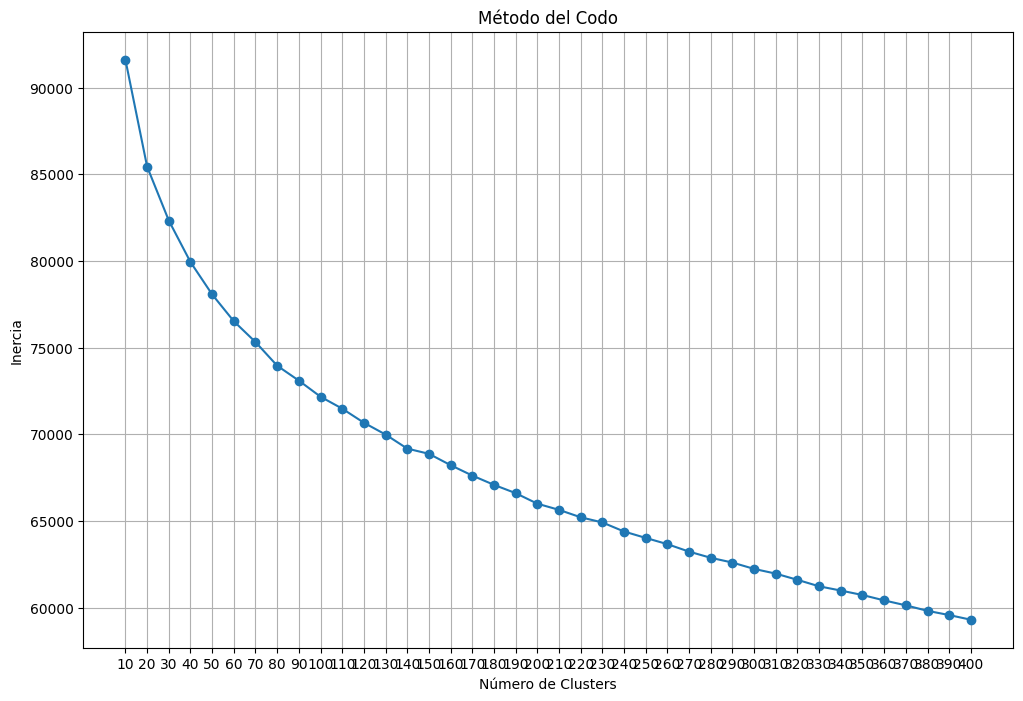

In [ ]:
# Convert anime_embeddings dictionary to a NumPy array
embedding_vectors = np.array(list(anime_embeddings.values()))

# Check for NaN values
print(f"Number of NaN values: {np.isnan(embedding_vectors).sum()}")

# Método del codo
inertia = []
cluster_range = range(10, 410, 10)  # Evaluar de 1 a 10 clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embedding_vectors)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(12, 8))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.xticks(cluster_range)
plt.grid()
plt.show()


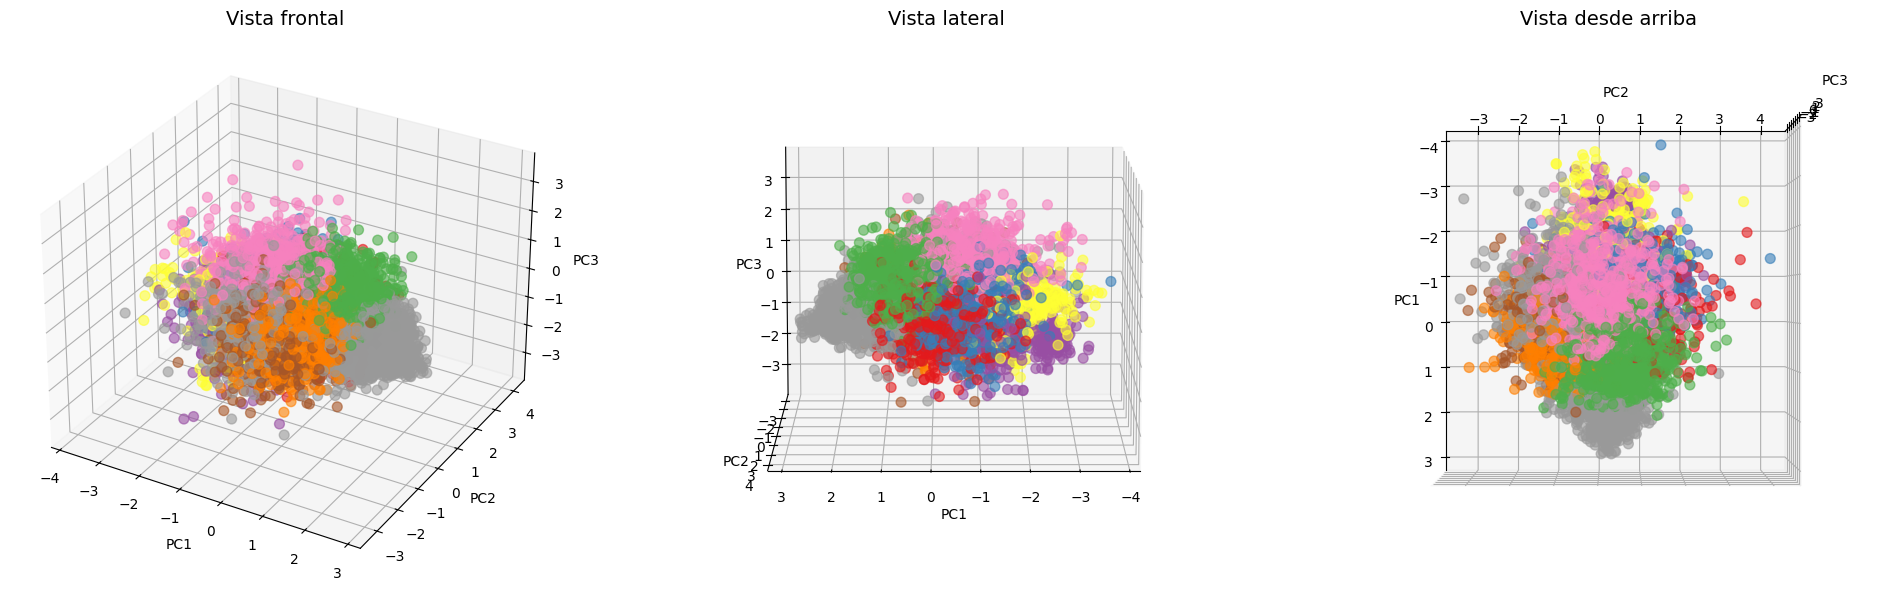

In [ ]:
# Supongamos que 'embeddings' es un array de vectores de embeddings (cada fila es un vector de características)
# Aquí generamos un ejemplo aleatorio con 100 puntos y 50 dimensiones

# we use this variable --> embedding_vectors

# Supongamos que embedding_vectors ya está definido
# Paso 1: Aplicar KMeans
# Supongamos que embedding_vectors ya está definido
# Paso 1: Aplicar KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(embedding_vectors)

# Paso 2: Obtener los resultados del clustering
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Paso 3: Reducir la dimensionalidad a 3 componentes para visualizar en 3D
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embedding_vectors)
reduced_centroids = pca.transform(centroids)

# Paso 4: Visualizar diferentes perspectivas en 3D
fig = plt.figure(figsize=(20, 6))

# Perspectiva 1: Vista desde un ángulo frontal
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=labels, cmap="Set1", s=50, alpha=0.6)
ax1.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], reduced_centroids[:, 2], marker='X', s=200, color='black', label='Centroides')
ax1.set_title("Vista frontal", fontsize=14)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")

# Perspectiva 2: Vista desde un ángulo lateral
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=labels, cmap="Set1", s=50, alpha=0.6)
ax2.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], reduced_centroids[:, 2], marker='X', s=200, color='black', label='Centroides')
ax2.view_init(elev=10, azim=90)  # Cambiamos el ángulo de visión
ax2.set_title("Vista lateral", fontsize=14)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")

# Perspectiva 3: Vista desde arriba
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=labels, cmap="Set1", s=50, alpha=0.6)
ax3.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], reduced_centroids[:, 2], marker='X', s=200, color='black', label='Centroides')
ax3.view_init(elev=90, azim=0)  # Cambiamos el ángulo de visión
ax3.set_title("Vista desde arriba", fontsize=14)
ax3.set_xlabel("PC1")
ax3.set_ylabel("PC2")
ax3.set_zlabel("PC3")

# Ajustar el diseño
plt.tight_layout()
plt.show()

> This is intended to provide an understanding of our approach. In our case, we are working with over 150 clusters, but visualizing such a large number is not very clear. Therefore, we have created a visualization with 10 clusters to give you a clearer idea of our process.





In [ ]:
embedding_vectors = np.array(list(anime_embeddings.values()))
optimal_k = 150
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(embedding_vectors)

# Obtain the labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

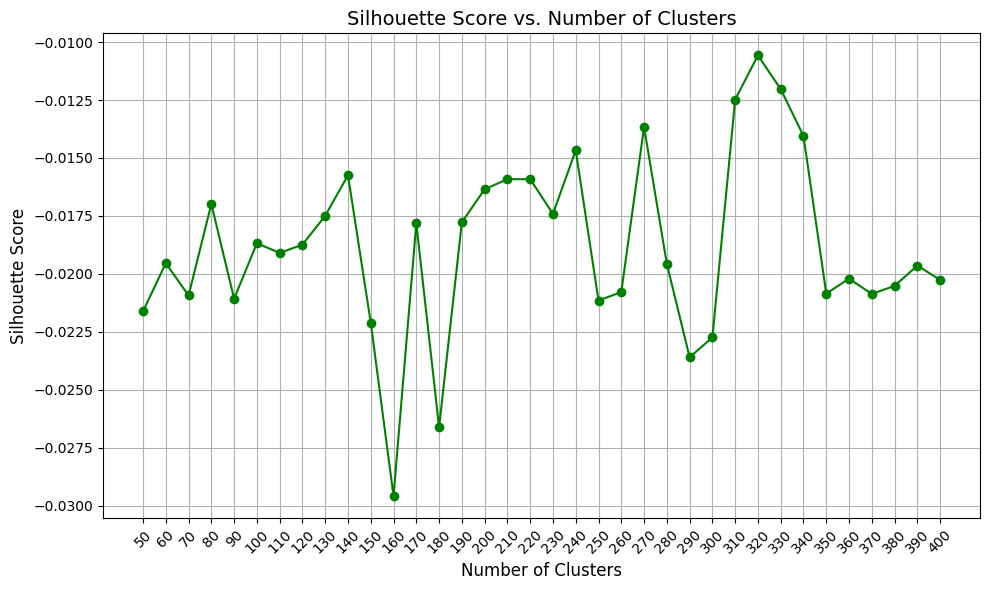

In [ ]:
from sklearn.metrics import silhouette_score
def compute_silhouette_scores(embeddings, start, end):
    '''
    compute silhouette_scores
    Parameters:
    embeddings (ndarray): The data points to be clustered.
    start (int): Starting number of clusters (inclusive).
    end (int): Ending number of clusters (inclusive).

    Returns:
    dict: A dictionary with cluster numbers as keys and their silhouette_scores as values.
    '''
    scores = {}
    for num_clusters in range(start, end + 1, 10):
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        sil_score = silhouette_score(embeddings, labels)
        scores[num_clusters] = sil_score

    return scores

def plot_silhouette_scores(scores):
    cluster_counts = list(scores.keys())
    sil_scores = list(scores.values())

    plt.figure(figsize=(10, 6))
    plt.plot(cluster_counts, sil_scores, marker='o', linestyle='-', color='g')
    plt.title("Silhouette Score vs. Number of Clusters", fontsize=14)
    plt.xlabel("Number of Clusters", fontsize=12)
    plt.ylabel("Silhouette Score", fontsize=12)
    plt.grid(True)
    plt.xticks(cluster_counts, rotation=45)
    plt.tight_layout()
    plt.show()

scores = compute_silhouette_scores(embedding_vectors, 50, 400)
plot_silhouette_scores(scores)

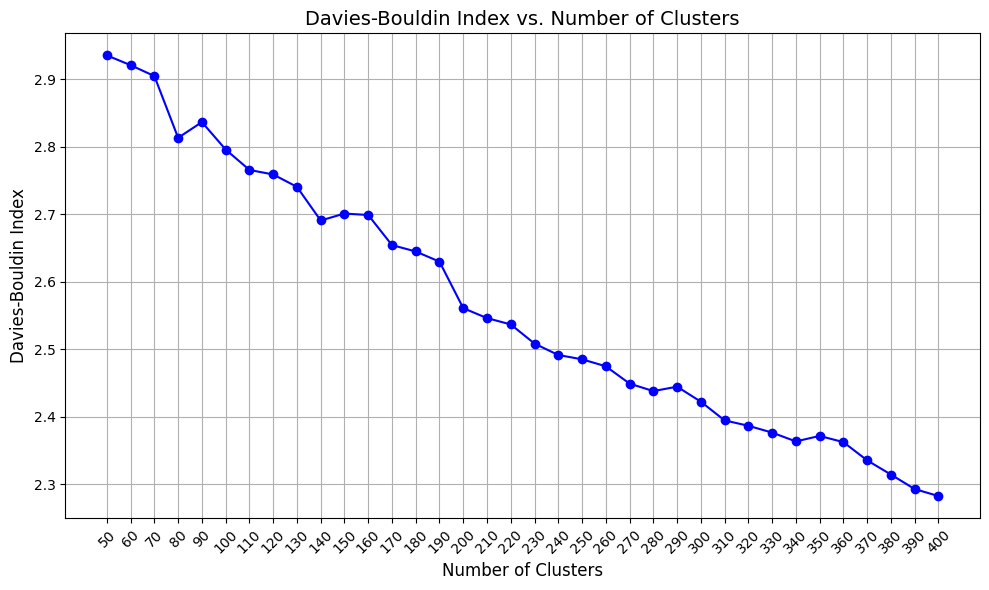

In [ ]:
from sklearn.metrics import davies_bouldin_score
def compute_davies_bouldin(embeddings, start, end):
  '''
  compute davies-bouldin Index
  Parameters:
  embeddings (ndarray): The data points to be clustered.
  start (int): Starting number of clusters (inclusive).
  end (int): Ending number of clusters (inclusive).

  Returns:
  dict: A dictionary with cluster numbers as keys and their davies_bouldin_score as values.
  '''
  score = {}
  for num_clusters in range(start, end + 1, 10):
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    db_score = davies_bouldin_score(embedding_vectors, labels)
    score[num_clusters] = db_score

  return score

def plot_davies_bouldin(score):
    cluster_counts = list(score.keys())
    db_scores = list(score.values())

    plt.figure(figsize=(10, 6))
    plt.plot(cluster_counts, db_scores, marker='o', linestyle='-', color='b')
    plt.title("Davies-Bouldin Index vs. Number of Clusters", fontsize=14)
    plt.xlabel("Number of Clusters", fontsize=12)
    plt.ylabel("Davies-Bouldin Index", fontsize=12)
    plt.grid(True)
    plt.xticks(cluster_counts, rotation=45)
    plt.tight_layout()
    plt.show()

score = compute_davies_bouldin(embedding_vectors, 50, 400)
plot_davies_bouldin(score)

In [ ]:
# Function to compute normalized entropy for a range of cluster numbers
def compute_entropy(embeddings, start, end):
    """
    Compute the normalized cross entropy for a range of cluster numbers.

    Parameters:
    embeddings (ndarray): The data points to be clustered.
    start (int): Starting number of clusters (inclusive).
    end (int): Ending number of clusters (inclusive).

    Returns:
    dict: A dictionary with cluster numbers as keys and their corresponding normalized entropies as values.
    """
    entropy_results = {}

    for num_clusters in range(start, end + 1, 10):
        # Apply k-means clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        labels = kmeans.fit_predict(embeddings)

        # Count elements in each cluster
        cluster_counts = np.bincount(labels, minlength=num_clusters)

        # Normalize counts to probabilities
        cluster_probs = cluster_counts / cluster_counts.sum()

        # Compute entropy
        cluster_entropy = entropy(cluster_probs, base=2)  # Base 2 for interpretability
        entropy_results[num_clusters] = cluster_entropy

    # Normalize the entropy values to range [0, 1]
    min_entropy = min(entropy_results.values())
    max_entropy = max(entropy_results.values())
    normalized_entropy_results = {
        k: (v - min_entropy) / (max_entropy - min_entropy)
        for k, v in entropy_results.items()
    }

    return normalized_entropy_results



In [ ]:
entropy_values = compute_entropy(embedding_vectors, 100, 300)

# Print results
for clusters, ent in entropy_values.items():
    print(f"Clusters: {clusters}, Entropy: {ent}")

Clusters: 100, Entropy: 0.0
Clusters: 110, Entropy: 0.09125829258793226
Clusters: 120, Entropy: 0.17477796074949553
Clusters: 130, Entropy: 0.2487242711659109
Clusters: 140, Entropy: 0.3155633817022975
Clusters: 150, Entropy: 0.38075381762449145
Clusters: 160, Entropy: 0.4505579949722298
Clusters: 170, Entropy: 0.4842961883494777
Clusters: 180, Entropy: 0.5545365277478386
Clusters: 190, Entropy: 0.5983803051993887
Clusters: 200, Entropy: 0.6377002423895732
Clusters: 210, Entropy: 0.6820892413231942
Clusters: 220, Entropy: 0.7242709065924732
Clusters: 230, Entropy: 0.7666109245164571
Clusters: 240, Entropy: 0.7909516781835908
Clusters: 250, Entropy: 0.8410882833029942
Clusters: 260, Entropy: 0.8700745965803932
Clusters: 270, Entropy: 0.8873589890847118
Clusters: 280, Entropy: 0.9277390330289336
Clusters: 290, Entropy: 0.9704977986493126
Clusters: 300, Entropy: 1.0


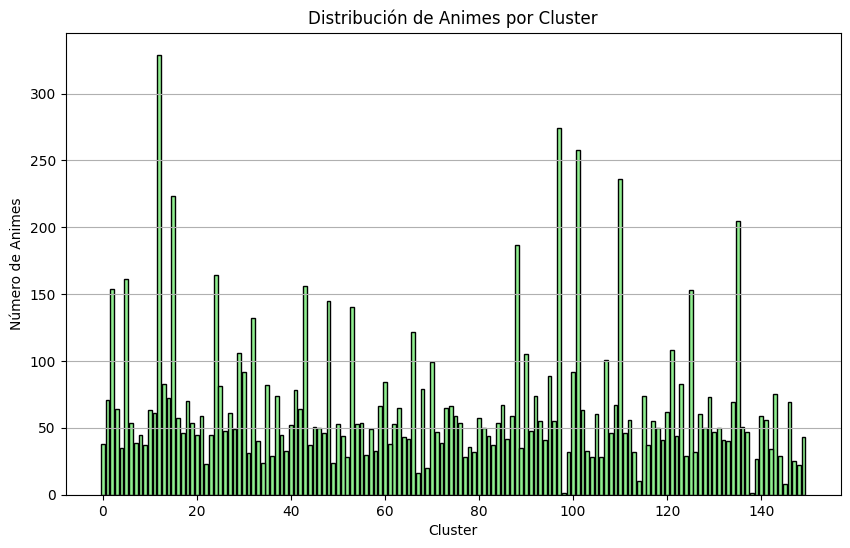

In [ ]:
from collections import Counter # PASS THIS INTO THE FIRST CODE LINE TO HAVE ALL THINGS TOGETHER

# How many animes do we have in each cluster?
cluster_counts = Counter(labels)

# Graficar la distribución de animes por cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.keys(), cluster_counts.values(), color='lightgreen', edgecolor='black')
plt.title("Distribución de Animes por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Número de Animes")
plt.grid(axis='y')
plt.show()

### Using Kmeans to get predictions



In [ ]:
def get_closest_cluster(centroids, target_embedding):
    """
    Determines the index of the closest cluster to a target embedding.

    Args:
        centroids (iterable): A collection of cluster centroids, where each centroid is a vector.
        target_embedding (jnp.ndarray): The target embedding vector to compare against the centroids.

    Returns:
        int: The index of the closest cluster to the target embedding.
    """
    # Convert the centroids to a JAX array

    centroids = jnp.array(list(centroids))

    # Calculate the Euclidean distances between the target embedding and each centroid
    distances = jnp.linalg.norm(centroids - target_embedding, axis=1)

    # Get the index of the smallest distance (closest cluster)
    indices = jnp.argsort(distances)[0]

    return indices

In [ ]:
def highest_anime_rated_in_cluster(labels, cluster_id, embeddings_dict, mapped_to_real_anime_id, k, seen_anime_ids):
    """
    Retrieves the highest-rated animes within a specified cluster, excluding those already seen by the user.

    Args:
        labels (list): Cluster labels for all anime embeddings, where each label corresponds to a cluster ID.
        cluster_id (int): The ID of the cluster from which to retrieve animes.
        embeddings_dict (dict): A dictionary mapping anime IDs to their embeddings.
        mapped_to_real_anime_id (dict): A dictionary mapping internal anime IDs to real-world anime IDs.
        k (int): The number of top-rated animes to return. Use `-1` to return all animes in the cluster.
        seen_anime_ids (list): A list of anime IDs that the user has already seen.

    Returns:
        pd.DataFrame: A DataFrame containing the top-rated animes in the cluster, sorted by weighted score.
                      Includes columns: `anime_id`, `name`, `genre`, `type`, `episodes`, `rating`, and `members`.
    """

    labels_array = np.array(labels)
    indx =  np.where(labels_array == cluster_id)[0].tolist() # get the indexes of the same cluster

    # take the id of the movies of the same cluster and filter out seen animes
    animes_ids_same_cluster = [
        list(embeddings_dict.keys())[i]
        for i in indx
        if list(embeddings_dict.keys())[i] not in seen_anime_ids
        ]

    anime_info = get_anime_info(animes_ids_same_cluster, mapped_to_real_anime_id)

    anime_info_score = apply_weighted_score(anime_info)

    # Sort the dataset by the weighted score and select the top N recommendations
    if k == -1:
      top_recommendations = anime_info_score.sort_values(by='weighted_score', ascending=False)
      return top_recommendations[['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']]

    else:
      top_recommendations = anime_info_score.sort_values(by='weighted_score', ascending=False).head(k)
      return top_recommendations[['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']]


In [ ]:
# Recommending with k means
user_embedding, anime_ids = calculate_user_embedding_weighted_avg(ratings_unseen_df["user_id"][20],restored_model_state, rec_system_loaded)
close_cluster_id = get_closest_cluster(centroids, user_embedding)
highest_anime_rated_in_cluster(labels, close_cluster_id, anime_embeddings, mapped_to_real_anime_id, 5, anime_ids)

,anime_id,name,genre,type,episodes,rating,members
3974,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
5689,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
1393,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
2658,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888
1431,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151


## Gaussian Mixature

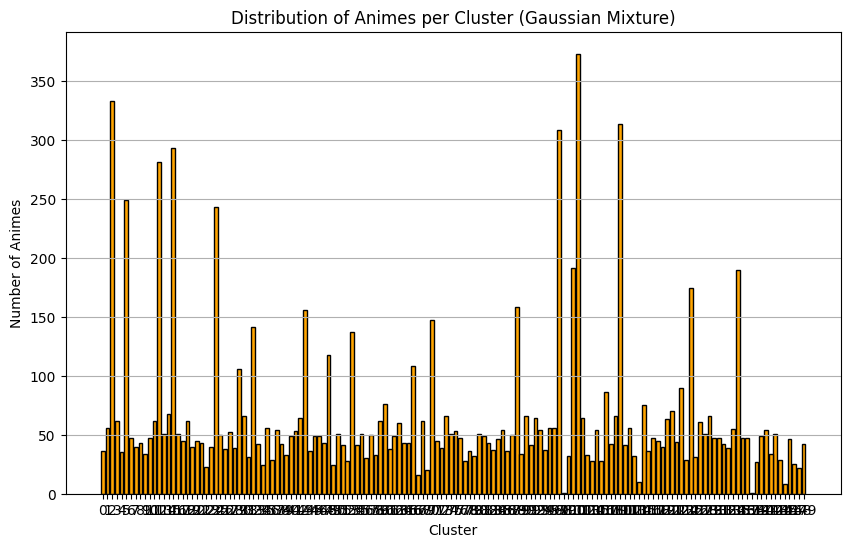

In [ ]:
from collections import Counter
from sklearn.mixture import GaussianMixture  #MOVE THIS

# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm.fit(embedding_vectors)

# Get the cluster labels
labels = gmm.predict(embedding_vectors)

# Count how many animes are in each cluster
cluster_counts = Counter(labels)

# Visualize the distribution of animes per cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.keys(), cluster_counts.values(), color='orange', edgecolor='black')
plt.title("Distribution of Animes per Cluster (Gaussian Mixture)")
plt.xlabel("Cluster")
plt.ylabel("Number of Animes")
plt.xticks(range(optimal_k))
plt.grid(axis='y')
plt.show()


In [ ]:
user_embedding, anime_ids = calculate_user_embedding_weighted_avg(ratings_unseen_df["user_id"][20],restored_model_state, rec_system_loaded)
close_cluster_id = gmm.predict(user_embedding.reshape(1,-1))[0]
highest_anime_rated_in_cluster(labels, close_cluster_id, anime_embeddings, mapped_to_real_anime_id,10, anime_ids)

,anime_id,name,genre,type,episodes,rating,members
3974,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
5689,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
1393,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
1431,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
2658,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888
7466,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
3539,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749
6486,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
10474,30276,One Punch Man,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,12,8.82,552458
8902,23273,Shigatsu wa Kimi no Uso,"Drama, Music, Romance, School, Shounen",TV,22,8.92,416397


# Cold Start Problem

> Due to the nature of our dataset, we can effectively address the cold start problem for new users who have not rated any anime. To achieve this, we will utilize the average rating of each anime, while also considering the number of members who have rated it. This approach aims to recommend highly-rated anime with a substantial number of ratings, ensuring both popularity and reliability in the recommendations.



In [ ]:
def cold_start_recommendation(dataset, top_n=10):
    """
    Generates a recommendation list to address the cold start problem for new users.

    Parameters:
        dataset (pd.DataFrame): A dataset containing anime information:.
        top_n (int): Number of top recommendations to return (default is 10).

    Returns:
        pd.DataFrame: A DataFrame of the top recommended anime sorted by weighted score.
    """
    new_dataset = apply_weighted_score(dataset)

    # Sort the dataset by the weighted score and select the top N recommendations
    top_recommendations = new_dataset.sort_values(by='weighted_score', ascending=False).head(top_n)

    return top_recommendations[['anime_id', 'name', 'genre', 'type', 'episodes', 'rating','members']]

In [ ]:
anime_info = get_anime_info(anime_ids, mapped_to_real_anime_id)
cold_start_recommendation(anime_info, top_n=10)

,anime_id,name,genre,type,episodes,members
6025,9989,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,"Drama, Slice of Life, Supernatural",TV,11,463835
4640,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,717796
4732,6746,Durarara!!,"Action, Mystery, Supernatural",TV,24,556431
4711,6702,Fairy Tail,"Action, Adventure, Comedy, Fantasy, Magic, Sho...",TV,175,584590
8885,23199,Durarara!!x2 Shou,"Action, Mystery, Supernatural",TV,12,189407
7224,15039,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,"Drama, Slice of Life, Supernatural",Movie,1,95241
9505,26213,Free!: Eternal Summer Special,"Comedy, School, Slice of Life",Special,1,36091
9117,24151,Ao Haru Ride OVA,"Romance, School, Shoujo, Slice of Life",OVA,2,46864
6023,9982,Fairy Tail OVA,"Comedy, Ecchi, Fantasy, Magic, Shounen",OVA,5,83421
8653,22265,Free!: Eternal Summer,"Comedy, School, Slice of Life, Sports",TV,13,150596


## Using half of the ratings

> For unseen users, we evaluate the recommendation system by splitting their recommendations into two halves. We use the first half as input to predict their preferences and compare the predicted recommendations to the second half. The similarity is measured using standard metrics like Precision@K (how many predictions are relevant) or Recall@K (how many relevant items are predicted). This approach checks how well the model generalizes to unseen users and predicts their interests.

In [ ]:
def split_and_compute_embedding(user_id, state, model):

    """
    Splits a user's unseen anime data into training and evaluation subsets, then computes the user's
    weighted average embedding using the training data.

    Args:
        user_id (int): The ID of the user for whom embeddings are being computed.
        state (Flax State): The model state containing parameters for embedding computation.
        model (object): The model instance with a method `get_item_embeddings` for computing anime embeddings.

    Returns:
        tuple:
            - user_embedding (np.ndarray): The user's weighted average embedding based on training data.
            - train_anime_ids (np.ndarray): Array of anime IDs used in the training subset.
            - eval_anime_ids (np.ndarray): Array of anime IDs used in the evaluation subset.
    """

    cols_of_interest = ["user_id", "anime_id", "user_rating"]
    user_data = ratings_unseen_df[ratings_unseen_df["user_id"] == user_id][cols_of_interest]

    anime_ids = user_data["anime_id"].values
    ratings = user_data["user_rating"].values

    # Shuffle indices and split into two halves
    indices = list(range(len(anime_ids)))
    random.shuffle(indices)
    half = len(indices) // 2
    train_indices = indices[:half]
    eval_indices = indices[half:]

    # Training data
    train_anime_ids = anime_ids[train_indices]
    train_ratings = ratings[train_indices]

    # Evaluation data
    eval_anime_ids = anime_ids[eval_indices]
    eval_ratings = ratings[eval_indices]

    # Compute weighted average embedding using training data
    weighted_sum = np.zeros_like(state.apply_fn(state.params, method=model.get_item_embeddings, item_ids=train_anime_ids[0]))
    total_weight = 0

    for i in range(len(train_anime_ids)):
        weighted_sum += train_ratings[i] * state.apply_fn(state.params, method=model.get_item_embeddings, item_ids=train_anime_ids[i])
        total_weight += train_ratings[i]

    user_embedding = weighted_sum / total_weight

    return user_embedding, train_anime_ids, eval_anime_ids

In [ ]:
def precision_at_k(predicted_anime_ids, evaluation_anime_ids, k):
    """
    Computes the precision at k.

    Args:
        predicted_anime_ids (list): List of predicted anime IDs in ranked order.
        evaluation_anime_ids (list): List of actual anime IDs for evaluation.
        k (int): The number of top predictions to consider.

    Returns:
        float: precision.
    """

    predicted = predicted_anime_ids[:k]
    relevant_count = sum(1 for anime_id in predicted if anime_id in evaluation_anime_ids)

    return relevant_count / k if k > 0 else 0.0

In [ ]:
def ap_at_k(predicted_anime_ids, evaluation_anime_ids, k):
    """
    computes the average precision at k

    Args:
        predicted_anime_ids (list): List of predicted anime IDs in ranked order.
        evaluation_anime_ids (list): List of actual anime IDs for evaluation.
        k (int): The number of top predictions to consider.

    Returns:
        float: average precision.
    """
    #  Average Precision
    predicted = predicted_anime_ids[:k]

    hits = 0
    precision_sum = 0

    for idx, anime_id in enumerate(predicted):
        if anime_id in evaluation_anime_ids:
            hits += 1
            precision_sum += hits / (idx + 1)

    # Average over the number of relevant items
    average_precision =  precision_sum / hits if hits else 0.0

    return average_precision

In [ ]:
def ndcg_at_k(predicted_anime_ids, evaluation_anime_ids, k):
    """
    Computes the NDCG score for the top-k predicted items.

    Args:
        predicted_anime_ids (list): List of predicted anime IDs in ranked order.
        evaluation_anime_ids (list): List of actual anime IDs for evaluation.
        k (int): The number of top predictions to consider.

    Returns:
        float: NDCG score.
    """
    # Limit predictions to top-k
    predicted = predicted_anime_ids[:k]

    # Relevance: 1 if predicted ID is in evaluation IDs, else 0
    relevance = [1 if anime_id in evaluation_anime_ids else 0 for anime_id in predicted]

    # Compute DCG (Discounted Cumulative Gain)
    dcg = sum([rel / np.log2(idx + 2) for idx, rel in enumerate(relevance)])

    # Compute Ideal DCG
    ideal_relevance = sorted(relevance, reverse=True)
    idcg = sum([rel / np.log2(idx + 2) for idx, rel in enumerate(ideal_relevance)])

    # Return NDCG (avoid division by zero)
    return dcg / idcg if idcg > 0 else 0.0

In [ ]:
def evaluation_method_1(unseen_users, method, state, model, centroids, labels, embeddings_dict, mapped_to_real_anime_dict,k):
    """
    Evaluates a recommendation method on unseen users by calculating the NDCG, precision, and recall at k.

    Args:
        unseen_users (DataFrame): A DataFrame containing information about users who have not been seen by the model yet.
        method (str): The recommendation method to use. Options are "kmeans" for k-means clustering and "weighted_average" for a weighted average recommendation.
        state (object): The state object containing parameters and methods for the model.
        model (object): The model that contains the item embeddings.
        centroids (array): The centroids of the clusters (used in the "kmeans" method).
        labels (array): The cluster labels for the items (used in the "kmeans" method).
        embeddings_dict (dict): A dictionary mapping anime IDs to their embeddings.
        mapped_to_real_anime_dict (dict): A dictionary mapping anime IDs to their real-world representations.
        k (int): The number of top recommendations to consider for precision, recall, and NDCG.

    Returns:
        tuple: A tuple containing the average NDCG, precision, and recall scores for the evaluated method.
    """

    total_ndcg = 0
    total_precision = 0
    total_recall = 0
    total_ap = 0
    count = 0

    for index, row in unseen_users.iterrows():

        if method == "kmeans":
            user_embedding, train_anime_ids, evaluation_anime_ids  = split_and_compute_embedding(row["user_id"],state, model)
            close_cluster_id = get_closest_cluster(centroids, user_embedding)
            predicted_anime_ids = highest_anime_rated_in_cluster(labels, close_cluster_id, embeddings_dict, mapped_to_real_anime_dict,k, train_anime_ids)["anime_id"].values

        if method == "weighted_average":
            user_embedding, anime_ids_seen,evaluation_anime_ids  = split_and_compute_embedding(row["user_id"],state, model)
            closest_ids = get_top_k_closest(embeddings_dict, user_embedding, k=k, seen_animes_id=anime_ids_seen)
            predicted_anime_ids = get_anime_info(closest_ids, mapped_to_real_anime_id)["anime_id"].values

        ndcg_score = ndcg_at_k(predicted_anime_ids, evaluation_anime_ids, k)
        total_ndcg += ndcg_score
        total_precision += precision_at_k(predicted_anime_ids, evaluation_anime_ids, k)
        total_ap += ap_at_k(predicted_anime_ids, evaluation_anime_ids, k)
        count += 1

    # Return the average NDCG, average Precision, MAP
    avg_ndcg = total_ndcg / count if count > 0 else 0.0
    avg_precision = total_precision / count if count > 0 else 0.0
    mean_average_precision = total_ap / count if count > 0 else 0.0
    return avg_ndcg, avg_precision, mean_average_precision


In [ ]:
avg_ndcg, avg_precision, map = evaluation_method_1(ratings_unseen_df.head(500),"kmeans",restored_model_state, rec_system_loaded, centroids, labels,anime_embeddings ,mapped_to_real_anime_id,10)
print(f"Average Precision: {avg_precision:.4f}")
print(f"Mean Average Precision: {map:.4f}")
print(f"Average NDCG: {avg_ndcg:.4f}")

Average Precision: 0.0254
Mean Average Precision: 0.0560
Average NDCG: 0.0911


In [ ]:
avg_ndcg, avg_precision, map = evaluation_method_1(ratings_unseen_df.head(500),"weighted_average",restored_model_state, rec_system_loaded, centroids, labels,anime_embeddings ,mapped_to_real_anime_id,10)
print(f"Average Precision: {avg_precision:.4f}")
print(f"Mean Average Precision: {map:.4f}")
print(f"Average NDCG: {avg_ndcg:.4f}")

Average Precision: 0.0148
Mean Average Precision: 0.0803
Average NDCG: 0.0920


## ChatGPT as a Judge

In [ ]:
def new_user_recommendation_v2(user_id, model, state, anime_embeddings_dict, mapped_to_real_anime_dict):

    """
    Recommends anime to a new user based on their weighted average user embedding.

    Args:
        user_id (int): The ID of the user for whom the recommendations are to be generated.
        model (object): The model that contains the item embeddings.
        state (object): The state object containing parameters and methods for the model.
        anime_embeddings_dict (dict): A dictionary mapping anime IDs to their embeddings.
        mapped_to_real_anime_dict (dict): A dictionary mapping anime IDs to their real-world representations.

    Returns:
        tuple: A tuple containing two elements:
            - anime_info (DataFrame): Information about the recommended anime (such as ID, name, genre, etc.).
            - anime_ids_seen (array): A list of anime IDs that the user has already seen.
    """

    user_embedding, anime_ids_seen = calculate_user_embedding_weighted_avg(user_id, state, model)
    closest_ids = get_top_k_closest(anime_embeddings_dict, user_embedding, k=5, seen_animes_id=anime_ids_seen)
    anime_info = get_anime_info(closest_ids, mapped_to_real_anime_dict)
    return anime_info, anime_ids_seen

In [ ]:
!pip install --force-reinstall -v "openai==1.55.3"
!pip install httpx==0.27.2
# restart session

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Obtaining dependency information for openai==1.55.3 from https://files.pythonhosted.org/packages/10/06/691ef3f0112ecf0d7420d0bf35b5d16cf81554141f4b4913a9831031013d/openai-1.55.3-py3-none-any.whl.metadata
  Obtaining dependency information for anyio<5,>=3.5.0 from https://files.pythonhosted.org/packages/a0/7a/4daaf3b6c08ad7ceffea4634ec206faeff697526421c20f07628c7372156/anyio-4.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for distro<2,>=1.7.0 from https://files.pythonhosted.org/packages/12/b3/231ffd4ab1fc9d679809f356cebee130ac7daa00d6d6f3206dd4fd137e9e/distro-1.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for httpx<1,>=0.23.0 from https://files.pythonhosted.org/packages/2a/39/e50c7c3a983047577ee07d2a9e53faf5a69493943ec3f6a384bdc792deb2/httpx-0.28.1-py3-none-any.whl.metadata
  Obtaining dependency information for jiter<1,>=0.4.0 from https://files.pythonhosted.org/pack

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1


In [ ]:
from openai import OpenAI

def gpt3_evaluate_recommendations(seen_anime_names, predicted_anime_names, user_id):

    """
    Evaluates the quality of anime recommendations based on the user's seen anime using GPT-3.

    This function uses the GPT-3 model to assess the relevance and quality of a set of recommended anime for a user
    by comparing it to the user's previously watched anime. It generates a detailed evaluation with a score and explanation.

    Args:
        seen_anime_names (list of str): A list of names of anime that the user has already watched and rated.
        predicted_anime_names (list of str): A list of names of anime recommended for the user.

    Returns:
        str: A detailed evaluation from GPT-3 containing a score (1-10) and a short explanation for each recommended anime.

    Raises:
        Exception: If there is an issue with the API request or the response.
    """

    # Limit number
    n = 3
    seen_anime_names = seen_anime_names[:n]
    predicted_anime_names = predicted_anime_names[:n]

    # Prepare input prompt
    seen_anime_str = "\n".join([f"1. {anime_name}" for anime_name in seen_anime_names])
    predicted_anime_str = "\n".join([f"1. {anime_name}" for anime_name in predicted_anime_names])

    prompt = (
        f"You are an expert in anime recommendations.\n\n"
        f"Current user id is {user_id}\n"
        f"The user has watched and rated the following anime:\n{seen_anime_str}\n\n"
        f"Here are recommended animes for this user:\n{predicted_anime_str}\n\n"
        f"Firstly, say for this user id, the watched and rated animes list is ... without a score behind it"
        f"Then say for this user id the animes recommended list is ..."
        f"Finally, evaluate the quality for each anime recommendations on a scale from 1 to 10."
        f"And provide a short explanation for your rating of recommended animes behind the score\n"
        f"Give a average score of your rating and Briefly summarize the style comparison between the recommended anime and the anime the user has seen"
    )

    client = OpenAI(
        api_key="sk-AGC1o2pX99PKLhOOtKC8omzvI40AAoXn6ogX3AF784adVENK",
        base_url="https://api.chatanywhere.tech/v1"
    )
    llm = "gpt-3.5-turbo"
    chat_completion = client.chat.completions.create(
        model=llm,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt}
                ]
            }
        ],
    )

    # Extract and return the text content of the response
    result = chat_completion.choices[0].message.content
    print(f"{llm} Evaluation:\n {result}")

    return result


def evaluation_method_3(unseen_users, state, model, embeddings_dict, mapped_to_real_anime_dict):

    """
    Evaluates recommendations for new users by generating feedback through GPT-3.

    This method generates anime recommendations for users who have not been seen before (unseen users) and
    sends the recommendations along with the user's previously watched anime to GPT-3 for evaluation.
    The feedback generated is a detailed analysis of the recommendations' relevance, including a score and an explanation.

    Args:
        unseen_users (pandas.DataFrame): DataFrame containing information about users who haven't been seen in the recommendation system.
        state (object): The current state object of the model, which may include parameters or metadata needed for computation.
        model (object): The model used to generate anime recommendations.
        embeddings_dict (dict): A dictionary mapping anime IDs to their respective embeddings.
        mapped_to_real_anime_dict (dict): A dictionary mapping anime IDs to their real-world names.

    Returns:
        dict: A dictionary containing detailed feedback for each user, including a list of user IDs and their respective feedback evaluations.

    Example:
        result = evaluation_method_3(unseen_users, state, model, embeddings_dict, mapped_to_real_anime_dict)
        print(result["detailed_feedback"])
    """

    feedback_list = []

    for index, row in unseen_users.iterrows():
        user_id = row["user_id"]

        anime_pred_info, anime_seen_id = new_user_recommendation_v2(user_id, model, state, embeddings_dict, mapped_to_real_anime_dict)

        # Get the names of the predicted and seen animes
        predicted_anime_names = anime_pred_info['name'].values
        seen_anime_names = get_anime_info(anime_seen_id, mapped_to_real_anime_dict)['name'].values

        # Send to GPT-3 for evaluation (now we just get the full response)
        feedback = gpt3_evaluate_recommendations(seen_anime_names, predicted_anime_names, user_id)

        feedback_list.append(feedback)

    return feedback_list

In [ ]:
results = evaluation_method_3(
    unseen_users=ratings_unseen_df.head(10),  # Adjust the DataFrame as needed
    state=restored_model_state,              # The state of the model
    model=rec_system_loaded,                 # The recommendation system model
    embeddings_dict=anime_embeddings,        # Anime embeddings dictionary
    mapped_to_real_anime_dict=mapped_to_real_anime_id,  # Mapping from internal to real anime IDs
)

# Display the feedback
for feedback in results:
    print(f"{feedback}\n")

gpt-3.5-turbo Evaluation:
 For user ID 66004:
Watched and rated animes: 
1. Cowboy Bebop
2. Cowboy Bebop: Tengoku no Tobira
3. Trigun

Recommended animes: 
1. Kure-nai
2. Tetsuwan Birdy Decode
3. Nyan Koi!

Rating and explanation:
1. Kure-nai - 8/10: Kure-nai offers a mix of action, drama, and character development similar to Cowboy Bebop and Trigun. The story follows a young protagonist who gets involved in dangerous situations, much like the characters in the watched animes.
 
2. Tetsuwan Birdy Decode - 7/10: Tetsuwan Birdy Decode combines sci-fi elements with action, just like Cowboy Bebop. The series features a strong female lead and unique alien technology, which may appeal to fans of the user's watched list.

3. Nyan Koi! - 6/10: Nyan Koi! is a lighter, comedy-focused anime compared to the user's watched list, but it still includes elements of adventure and character relationships. It provides a more lighthearted break from the intense action of Cowboy Bebop and Trigun.

Average 

# TradeOff Performance / Accuracy


> In this section, we will analyze the performance of our model when implementing different techniques. Our focus will be on both performance and accuracy, exploring how to balance these two factors to achieve the most suitable model.

## TradeOff for Performance

We have the previously defined function, make_prediction, which, given a user, generates the predicted ratings for all the anime films in the database.

Next, we will design another function that, instead of generating predicted ratings for all the anime films in the database, uses the clusters to compute the predicted ratings only for the items in the nearest cluster.

This approach allows us to evaluate the balance between performance and accuracy.


In [ ]:
def calculate_user_embedding_weighted_avg_v2(user_id, state, model):

    """
    Calculates the user embedding using a weighted average of the embeddings of the anime they have rated.

    This method computes the weighted average of anime embeddings for a given user, where the weights are
    the ratings that the user has given to the anime. The embeddings of the rated anime are retrieved from
    the model, and the weighted sum of these embeddings is calculated to form the user's overall embedding.

    Args:
        user_id (int): The unique identifier of the user for whom the embedding is being calculated.
        state (object): The current state object of the model, which may include parameters or metadata needed for computation.
        model (object): The model used to generate anime embeddings.

    Returns:
        tuple: A tuple containing:
            - `user_embedding` (numpy.ndarray): The weighted average embedding of the user.
            - `anime_ids` (numpy.ndarray): The array of anime IDs the user has rated.

    Example:
        user_embedding, anime_ids = calculate_user_embedding_weighted_avg_v2(user_id, state, model)
        print(user_embedding)
    """

    cols_of_interest = ["user_id","anime_id","user_rating"]
    user_data = ratings_df[ratings_df["user_id"] == user_id][cols_of_interest]

    anime_ids = user_data["anime_id"].values
    ratings = user_data["user_rating"].values


    weighted_sum = np.zeros_like(state.apply_fn(state.params, method=model.get_item_embeddings, item_ids=anime_ids[0]))
    total_weight = 0

    for i in range(len(anime_ids)):
        weighted_sum += ratings[i] * state.apply_fn(state.params, method=model.get_item_embeddings, item_ids=anime_ids[i])
        total_weight += ratings[i]

    user_embedding = weighted_sum / total_weight
    return user_embedding, anime_ids

In [ ]:
def make_predictions_with_clusters(rng, rec_system, state, centroids, labels, embeddings_dict, user_id):

    """
    Makes anime rating predictions for a user by using a clustering-based approach.

    This function first computes the weighted average user embedding, then finds the closest cluster to this
    user embedding. The function retrieves the top-rated anime in the closest cluster and predicts ratings
    for these anime based on the user's embedding and the ratings data. The final predictions are rounded and
    returned in a sorted DataFrame.

    Args:
        rng (object): A random number generator instance, possibly for deterministic behavior in predictions.
        rec_system (object): The recommendation system object to compute the embeddings.
        state (object): The current state object of the model, which may include parameters or metadata needed for computation.
        centroids (numpy.ndarray): The centroids of the clusters used to group the anime embeddings.
        labels (numpy.ndarray): The cluster labels corresponding to each anime in the embeddings.
        embeddings_dict (dict): A dictionary containing the embeddings for each anime.
        user_id (int): The unique identifier of the user for whom the predictions are being made.

    Returns:
        pandas.DataFrame: A DataFrame containing the predicted ratings for anime in the closest cluster, sorted by prediction.
            - `user_id`: The ID of the user.
            - `anime_id`: The ID of the anime.
            - `pred_rating`: The predicted rating for each anime.
            - `name`: The name of the anime.

    Example:
        user_data = make_predictions_with_clusters(rng, rec_system, state, centroids, labels, embeddings_dict, user_id)
        print(user_data)
    """
    cols_of_interest = ["user_id","anime_id","user_rating","name"]

    user_embedding, anime_ids = calculate_user_embedding_weighted_avg_v2(user_id,state, rec_system)
    close_cluster_id = get_closest_cluster(centroids, user_embedding)
    animes_in_cluster = highest_anime_rated_in_cluster(labels, close_cluster_id, embeddings_dict, mapped_to_real_anime_id,-1, anime_ids)["anime_id"].values


    user_data = pd.DataFrame({
        "user_id": [user_id] * len(animes_in_cluster),
        "anime_id": animes_in_cluster,
    })
    user_data["anime_id"] = user_data["anime_id"].apply(lambda x: real_to_mapped_anime_id[x])

    preds = state.apply_fn(state.params, user_data[["user_id", "anime_id"]].values)


    preds = jnp.clip(preds,1, 10.5)
    preds = np.array([math.ceil(pred) if (pred-int(pred)) > 0.5 else math.floor(pred) for pred in preds])
    user_data["pred_rating"] = preds

    user_data = user_data.merge(ratings_df[["anime_id", "name"]].drop_duplicates(), on="anime_id", how="left")
    user_data = user_data.sort_values(by="pred_rating", ascending=False)

    return user_data


In [ ]:
def make_predictions_for_all_animes(rng, rec_system, state, centroids, labels, embeddings_dict, user_id):
    """
    Makes predictions for all anime in the dataset for a given user.

    This function predicts ratings for all anime in the dataset based on the user's embedding, applying the model
    to generate the predicted ratings. The predictions are then clipped, rounded, and returned in a DataFrame
    sorted by the predicted rating.

    Args:
        rng (object): A random number generator instance, possibly for deterministic behavior in predictions.
        rec_system (object): The recommendation system object to compute the embeddings.
        state (object): The current state object of the model, which may include parameters or metadata needed for computation.
        centroids (numpy.ndarray): The centroids of the clusters used to group the anime embeddings.
        labels (numpy.ndarray): The cluster labels corresponding to each anime in the embeddings.
        embeddings_dict (dict): A dictionary containing the embeddings for each anime.
        user_id (int): The unique identifier of the user for whom the predictions are being made.

    Returns:
        pandas.DataFrame: A DataFrame containing the predicted ratings for all anime in the dataset, sorted by prediction.
            - `user_id`: The ID of the user.
            - `anime_id`: The ID of the anime.
            - `pred_rating`: The predicted rating for each anime.
            - `name`: The name of the anime.

    Example:
        user_data = make_predictions_for_all_animes(rng, rec_system, state, centroids, labels, embeddings_dict, user_id)
        print(user_data)
    """

    # Specify the columns you want to include in the result
    cols_of_interest = ["user_id", "anime_id", "average_anime_rating", "name"]

    # Get all anime IDs in the dataset
    all_animes_in_dataset = ratings_df["anime_id"].unique()

    # Prepare the user-specific data but for all anime in the dataset
    # You still need to create a dataframe with the user_id and all anime_ids
    user_data = pd.DataFrame({
        "user_id": [user_id] * len(all_animes_in_dataset),
        "anime_id": all_animes_in_dataset,
    })

    # Make predictions for all the anime for this user
    preds = state.apply_fn(state.params, user_data[["user_id", "anime_id"]].values)

    # Post-process predictions (clip and round)
    preds = jnp.clip(preds, 1, 10.5)
    preds = np.array([math.ceil(pred) if (pred - int(pred)) > 0.5 else math.floor(pred) for pred in preds])

    # Add predictions to the user data
    user_data["pred_rating"] = preds

    # Optionally merge with the anime information from the ratings_df (if you want to display anime names, etc.)
    user_data = user_data.merge(ratings_df[["anime_id", "name"]].drop_duplicates(), on="anime_id", how="left")

    # Return the final formatted DataFrame for display
    user_data = user_data.sort_values(by="pred_rating", ascending=False)
    return user_data


In [ ]:
make_predictions_with_clusters(rng, rec_system_loaded, restored_model_state, centroids, labels, anime_embeddings, 4).head(20)

,user_id,anime_id,pred_rating,name
86,4,250,9,Gokukoku no Brynhildr
68,4,715,9,Hidan no Aria
22,4,1260,9,Shakugan no Shana III (Final)
74,4,532,9,Seiken Tsukai no World Break
24,4,259,9,Date A Live II
176,4,1320,9,Triage X
28,4,499,9,Sekirei: Pure Engagement
30,4,910,9,Ookami Shoujo to Kuro Ouji
65,4,922,9,Aldnoah.Zero 2nd Season
17,4,462,9,Zero no Tsukaima: Princesses no Rondo


In [ ]:
make_predictions_for_all_animes(rng, rec_system_loaded, restored_model_state, centroids, labels, anime_embeddings, 4).head(20)

,user_id,anime_id,pred_rating,name
3688,4,6917,10,Wakakusa Monogatari: Nan to Jo-sensei
4323,4,4636,10,Macross Dynamite 7
7046,4,4494,10,Furueru Kuchibiru Episode 0
7852,4,7190,10,Grander Musashi RV
4344,4,7199,10,Sekai Meisaku Douwa: Oyayubi Hime
3924,4,990,10,gdgd Fairies
6412,4,6389,10,Kuraibito
7247,4,4018,10,Omoi no Kakera
4338,4,6525,10,Kounai Shasei
5389,4,5702,10,Koukou Tekken-den Tough


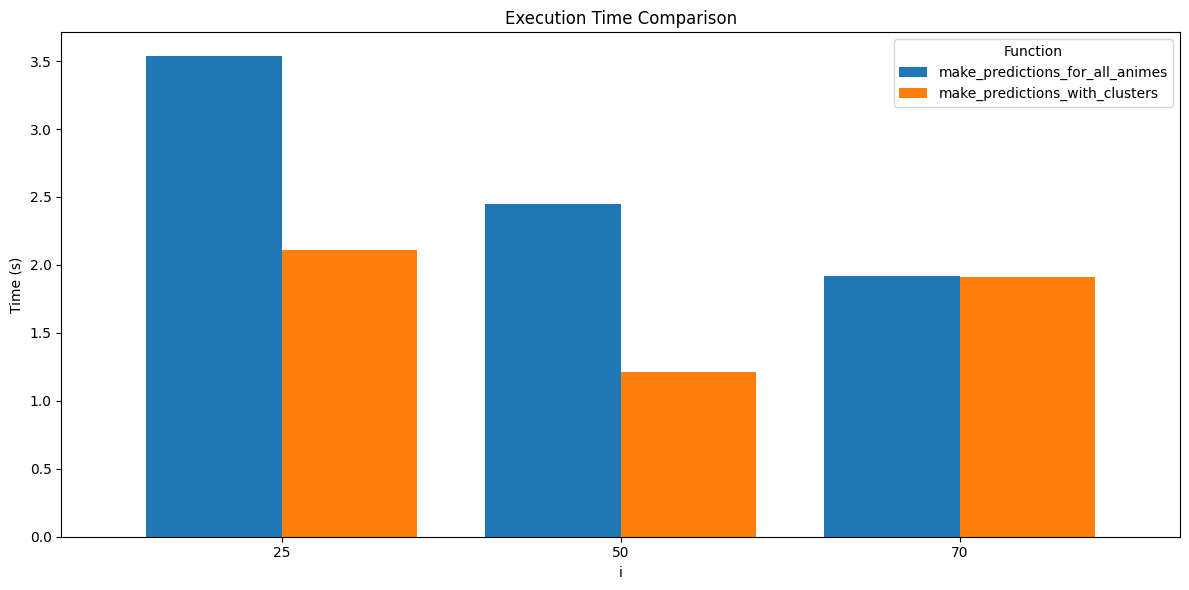

In [ ]:
# Install memory_profiler (if not already installed)
!pip install memory-profiler

import time
import matplotlib.pyplot as plt
import pandas as pd

def analyze_execution_time(func, *args):
    """
    Measures and returns the execution time of a given function.

    This function takes another function as input, along with any arguments that should be passed to that function.
    It measures the time taken by the function to execute and returns the time in seconds.

    Args:
        func (callable): The function whose execution time needs to be measured.
        *args: Arguments to be passed to the function `func`.

    Returns:
        float: The execution time in seconds.

    """
    # Measure execution time
    start_time = time.time()
    func(*args)  # Run the function with provided arguments
    end_time = time.time()
    execution_time = end_time - start_time
    return execution_time

# Values of i to analyze
selected_i_values = [25, 50, 70]

# Results storage
results = []

# Analyze for i = 25, 50, 70
for i in selected_i_values:
    # Analyze first function
    time1 = analyze_execution_time(
        make_predictions_with_clusters,
        rng, rec_system_loaded, restored_model_state, centroids, labels, anime_embeddings, i
    )
    # Analyze second function
    time2 = analyze_execution_time(
        make_predictions_for_all_animes,
        rng, rec_system_loaded, restored_model_state, centroids, labels, anime_embeddings, i
    )
    # Append results
    results.append({"i": i, "Function": "make_predictions_with_clusters", "Execution Time (s)": time1})
    results.append({"i": i, "Function": "make_predictions_for_all_animes", "Execution Time (s)": time2})

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Plot results
df_pivot_time = df_results.pivot(index="i", columns="Function", values="Execution Time (s)")

# Bar plot for execution time
df_pivot_time.plot(kind="bar", figsize=(12, 6), color=["#1f77b4", "#ff7f0e"], width=0.8)
plt.title("Execution Time Comparison")
plt.ylabel("Time (s)")
plt.xlabel("i")
plt.xticks(rotation=0)
plt.legend(title="Function")
plt.tight_layout()
plt.show()

# Display results
#print(df_results)

## TradeOff for Accuracy


In [ ]:
# First we are going to compute the average loss for 100 seen users from the model

In [ ]:
def calculate_mse_loss(rng, rec_system, state, user_id):
     """
    Calculates the Mean Squared Error (MSE) loss between predicted and actual ratings for a given user.

    This function computes the MSE loss by comparing the predicted ratings with the actual ratings for all animes
    that the user has interacted with. It first generates predictions for the user and then calculates the MSE.

    Args:
        rng (numpy.random.Generator): The random number generator used to seed and control random operations.
        rec_system (object): The recommendation system used to generate predictions.
        state (object): The model's state that contains the necessary parameters for making predictions.
        user_id (int): The ID of the user for whom predictions are being made.

    Returns:
        float: The MSE loss, which represents the average squared difference between the predicted and actual ratings.

    """
    # Get the user data with predictions
    user_data, user_id = make_predictions(rng, rec_system, state, user_id)

    # Extract actual and predicted ratings
    actual_ratings = user_data["user_rating"].values
    predicted_ratings = user_data["pred_rating"].values

    # Calculate MSE
    mse_loss = np.mean((predicted_ratings - actual_ratings) ** 2)
    return mse_loss

In [ ]:
rng = np.random.RandomState(2)

# Define the user group sizes
user_group_sizes = [50, 100, 250]

# Initialize a dictionary to store average MSE losses for each group size
average_mse_results = {}

# Iterate over the defined group sizes
for group_size in user_group_sizes:
    # Get the first `group_size` unique user IDs
    user_ids = ratings_df["user_id"].unique()[:group_size]

    # Initialize variables for accumulating MSE losses
    total_mse_loss = 0
    user_count = 0

    # Iterate over the user IDs for the current group size
    for user_id in user_ids:
        mse_loss = calculate_mse_loss(rng, rec_system_loaded, restored_model_state, user_id)
        total_mse_loss += mse_loss
        user_count += 1

    # Calculate the average MSE loss for the current group size
    average_mse = total_mse_loss / user_count if user_count > 0 else None
    average_mse_results[group_size] = average_mse

# Print the results
for group_size, avg_mse in average_mse_results.items():
    print(f"Average MSE loss for {group_size} users: {avg_mse}")
#user_data, user_id = make_predictions(rng,rec_system_loaded, restored_model_state,2)

Average MSE loss for 50 users: 2.5751680758024365
Average MSE loss for 100 users: 2.762867175326625
Average MSE loss for 250 users: 2.887258848734627


In [ ]:
# Here we are going to take the same 100 users as previously, but we are going to take into account only the animes in the cluster

In [ ]:
def calculate_mse_loss_clustering(rng, rec_system, state, user_id, centroids, labels, embeddings_dict):

    """
    Calculates the Mean Squared Error (MSE) loss between predicted and actual ratings for a given user,
    but only for the anime in the same cluster as the user, based on their embedding.

    This function computes the MSE loss by comparing the predicted ratings with the actual ratings for the
    animes that belong to the same cluster as the user. It first generates predictions for the user,
    finds the closest cluster, and then calculates the MSE for the animes in that cluster.

    Args:
        rng (numpy.random.Generator): The random number generator used to seed and control random operations.
        rec_system (object): The recommendation system used to generate predictions.
        state (object): The model's state that contains the necessary parameters for making predictions.
        user_id (int): The ID of the user for whom predictions are being made.
        centroids (array-like): The centroids of the clusters, representing the center points of each cluster.
        labels (array-like): The cluster labels corresponding to each anime.
        embeddings_dict (dict): A dictionary mapping anime IDs to their corresponding embeddings.

    Returns:
        float: The MSE loss for the user, calculated for the anime in the closest cluster. If there is no data
        or the MSE is NaN, it returns None.

    """
    # Get the user data with predictions
    user_data, user_id = make_predictions(rng, rec_system, state, user_id)

    # Find the closest cluster of the user
    user_embedding, anime_ids = calculate_user_embedding_weighted_avg_v2(user_id, state, rec_system)
    close_cluster_id = get_closest_cluster(centroids, user_embedding)

    # Take the anime ids for the same cluster
    labels_array = np.array(labels)
    indx = np.where(labels_array == close_cluster_id)[0].tolist()  # Get the indexes of the same cluster

    # Take the id of the movies of the same cluster and filter out seen animes
    animes_ids_same_cluster = [
        list(embeddings_dict.keys())[i]
        for i in indx
    ]

    # Filter user_data to include only animes in the same cluster
    user_data_filtered = user_data[user_data["anime_id"].isin(animes_ids_same_cluster)]

    # Check if filtered data is empty
    if user_data_filtered.empty:
        return None  # Or return float('nan') or 0 depending on your use case

    # Extract actual and predicted ratings for filtered data
    actual_ratings = user_data_filtered["user_rating"].values
    predicted_ratings = user_data_filtered["pred_rating"].values

    # Calculate MSE
    mse_loss = np.mean((predicted_ratings - actual_ratings) ** 2)

    # Check if mse_loss is NaN
    if np.isnan(mse_loss):
        return None  # Or another default value like 0 or float('nan')

    return mse_loss

In [ ]:
rng = np.random.RandomState(2)

# Define the user group sizes
user_group_sizes = [50, 100, 250]

# Initialize a dictionary to store average MSE losses for each group size
average_mse_cluster_results = {}

# Iterate over the defined group sizes
for group_size in user_group_sizes:
    # Get the first `group_size` unique user IDs
    user_ids = ratings_df["user_id"].unique()[:group_size]

    # Initialize variables for accumulating MSE losses
    total_mse_loss = 0
    user_count = 0

    # Iterate over the user IDs for the current group size
    for user_id in user_ids:
        mse_loss = calculate_mse_loss_clustering(rng, rec_system_loaded, restored_model_state, user_id, centroids, labels, anime_embeddings)
        if mse_loss is not None:  # Check if the MSE loss is valid
            total_mse_loss += mse_loss
            user_count += 1

    # Calculate the average MSE loss for the current group size
    average_mse_cluster = total_mse_loss / user_count if user_count > 0 else None
    average_mse_cluster_results[group_size] = average_mse_cluster

# Print the results
for group_size, avg_mse in average_mse_cluster_results.items():
    print(f"Average MSE loss for {group_size} users: {avg_mse}")

Average MSE loss for 50 users: 2.2987946316168846
Average MSE loss for 100 users: 2.691137756422824
Average MSE loss for 250 users: 2.8596438127651163


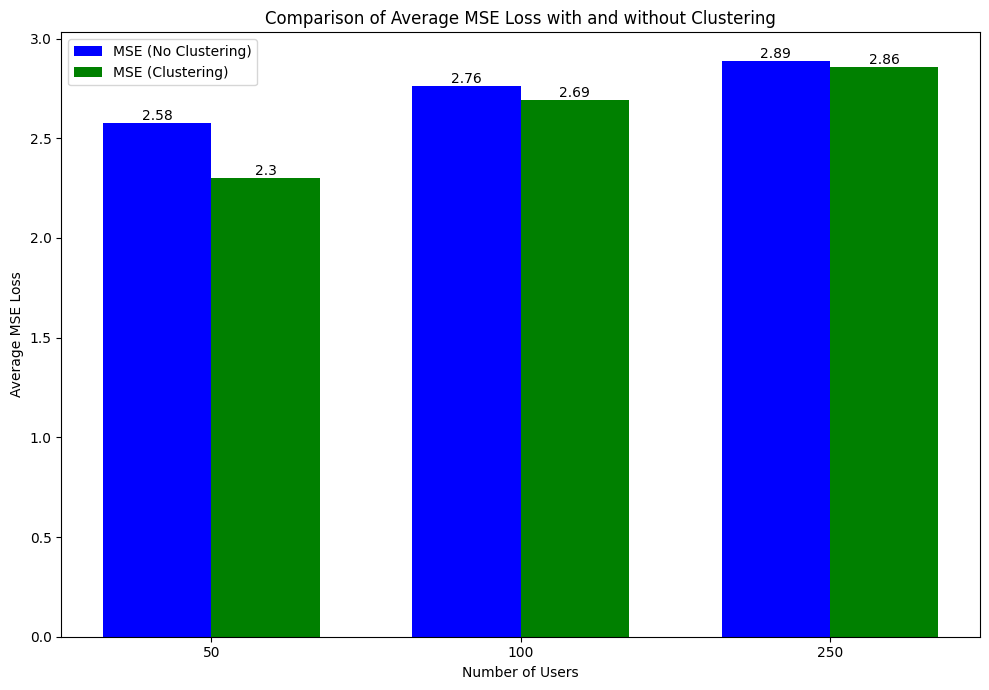

In [ ]:
# Prepare data for plotting
group_sizes = list(average_mse_results.keys())
average_mse_values = list(average_mse_results.values())
average_mse_cluster_values = list(average_mse_cluster_results.values())

# Create a bar plot
x = np.arange(len(group_sizes))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))

# Plotting both sets of MSE values
bars1 = ax.bar(x - width / 2, average_mse_values, width, label='MSE (No Clustering)', color='b')
bars2 = ax.bar(x + width / 2, average_mse_cluster_values, width, label='MSE (Clustering)', color='g')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Number of Users')
ax.set_ylabel('Average MSE Loss')
ax.set_title('Comparison of Average MSE Loss with and without Clustering')
ax.set_xticks(x)
ax.set_xticklabels(group_sizes)
ax.legend()

# Function to add value labels on the bars
def add_labels(bars):
    """
    Adds labels above the bars in a bar chart with their corresponding height value.

    This function takes a list of bars (matplotlib bar container objects), and for each bar,
    it calculates its height and places a text label centered above the bar showing the value.

    Args:
        bars (list): A list of matplotlib bar container objects (usually returned by plt.bar()).
    """
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Add labels to the bars
add_labels(bars1)
add_labels(bars2)

# Show the plot
plt.tight_layout()
plt.show()